In [1]:
# Cell 1: Imports and Setup
# Current time: Tuesday, August 19, 2025 at 10:43:32 PM IST
# Location: Mumbai, Maharashtra, India

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2  # OpenCV for image manipulation

print(f"Using TensorFlow Version: {tf.__version__}")

Using TensorFlow Version: 2.20.0


In [2]:
# Cell 2: Data Preparation (Dummy Dataset)

def create_dummy_dataset():
    """Creates a dummy dataset for demonstration purposes."""
    # Clean up previous runs
    if os.path.exists(r"D:\archive (1)\leapGestRecog"):
        shutil.rmtree(r"D:\archive (1)\leapGestRecog")
    
    # Configuration
    base_dir = r"D:\archive (1)\leapGestRecog"
    train_dir = os.path.join(base_dir, 'train')
    gestures = ['fist', 'palm', 'peace']
    num_samples_per_gesture = 50
    img_height, img_width = 96, 96
    
    print("Creating a dummy dataset for demonstration...")
    for gesture in gestures:
        gesture_path = os.path.join(train_dir, gesture)
        os.makedirs(gesture_path, exist_ok=True)
        for i in range(num_samples_per_gesture):
            image = np.zeros((img_height, img_width), dtype=np.uint8)
            if gesture == 'fist':
                cv2.circle(image, (img_height // 2, img_width // 2), 20, 200, -1)
            elif gesture == 'palm':
                cv2.rectangle(image, (img_height // 4, img_width // 4), ((img_height // 4) * 3, (img_width // 4) * 3), 220, -1)
            elif gesture == 'peace':
                cv2.line(image, (img_width // 2 - 15, img_height - 10), (img_width // 2 - 15, 30), 255, 10)
                cv2.line(image, (img_width // 2 + 15, img_height - 10), (img_width // 2 + 15, 30), 255, 10)
            noise = np.random.randint(0, 30, (img_height, img_width), dtype=np.uint8)
            image = cv2.add(image, noise)
            cv2.imwrite(os.path.join(gesture_path, f'img_{i}.png'), image)
            
    print("Dummy dataset created successfully.\n")
    return train_dir

# --- Create the dataset and set the data directory ---
# To use your REAL data, comment out the line below and set DATA_DIR manually.
# Example: DATA_DIR = r"D:\your_real_data_folder\train"
DATA_DIR = r"D:\your_real_data\train"

In [3]:
# Cell 3: Load and Preprocess Data (Corrected)

# Set the correct path to the folder containing your gesture subfolders
DATA_DIR = r"D:\archive (1)\leapGestRecog\train" 

# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96

# --- Create TensorFlow Datasets ---
# Notice how validation_split and subset are used together in both calls.

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,      # <-- This argument is present...
    subset="training",         # <-- ...so this one must be too.
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,      # <-- This argument is present...
    subset="validation",       # <-- ...so this one must be too.
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Found gestures: {class_names}")

# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 150 files belonging to 3 classes.


Using 120 files for training.
Found 150 files belonging to 3 classes.
Using 30 files for validation.
Found gestures: ['fist', 'palm', 'peace']


In [4]:
# Cell 4: Build the Model 🧠

# Data Augmentation and Preprocessing Layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])
rescale = tf.keras.layers.Rescaling(1./255)

# Define model architecture
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = rescale(x)
# Adapt grayscale to 3 channels for the pre-trained model
x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(x)

# Base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model
x = base_model(x, training=False)

# Custom classification head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

# Print the model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,833 (8.63 MB)

 Trainable params: 3,849 (15.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Cell 5: Compile and Train the Model 🚀

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4000 - loss: 1.1789 - val_accuracy: 1.0000 - val_loss: 0.4477
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.9500 - loss: 0.3261 - val_accuracy: 1.0000 - val_loss: 0.1000
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 1.0000 - loss: 0.0685 - val_accuracy: 1.0000 - val_loss: 0.0289
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch

In [6]:
# Run this cell after training to see exactly what keys are available
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])



--- Evaluating Model ---


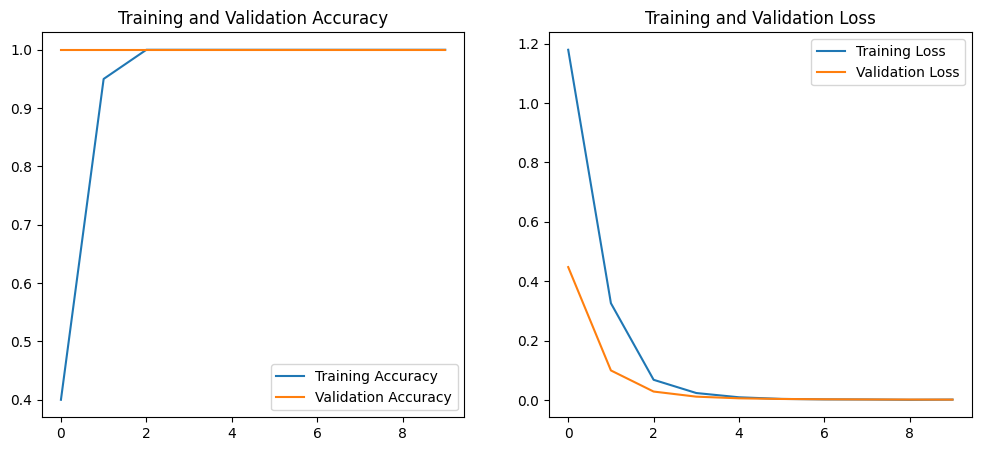


--- Visualizing Predictions on a Batch of Validation Data ---


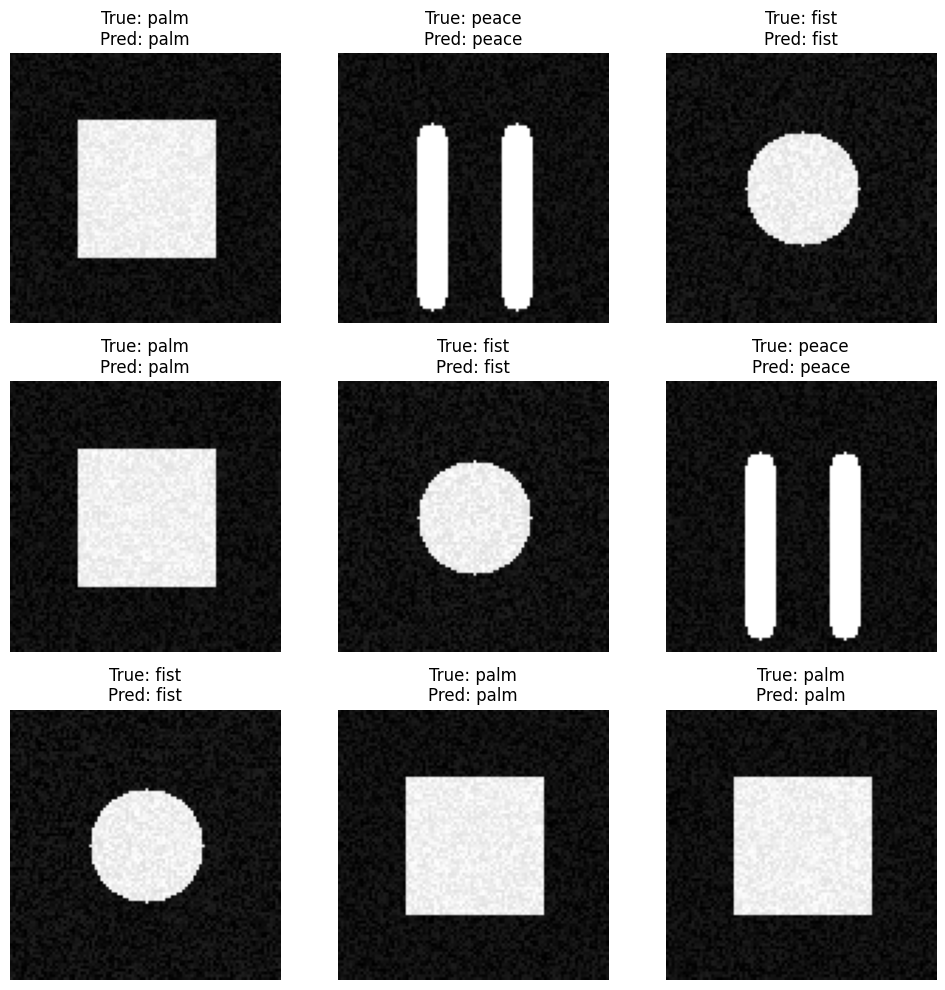

In [7]:
# Cell 6: Evaluate and Visualize Results (Corrected)

print("\n--- Evaluating Model ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # <-- CORRECTED KEY
loss = history.history['loss']
val_loss = history.history['val_loss']      # <-- CORRECTED KEY

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# --- The visualization part below should already be correct ---
print("\n--- Visualizing Predictions on a Batch of Validation Data ---")
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_indices = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image_batch[i].astype("uint8")), cmap='gray')
    plt.title(f"True: {class_names[label_batch[i]]}\nPred: {class_names[predicted_indices[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
# --- Save the Model ---
# Run this in your Jupyter notebook after training is finished.

model.save('hand_gesture_model.keras')
print("Model saved successfully as hand_gesture_model.keras")

Model saved successfully as hand_gesture_model.keras


In [9]:
# run_webcam.py

import cv2
import numpy as np
import tensorflow as tf

# --- Load the saved model ---
model = tf.keras.models.load_model('hand_gesture_model.keras')

# --- Define the class names (in the same order as training) ---
# IMPORTANT: Make sure this order is correct.
# You can get the correct order from the `class_names` variable in your notebook.
class_names = ['fist', 'palm', 'peace'] # Example: replace with your actual class names

# --- Model and Webcam Parameters ---
IMG_HEIGHT = 96
IMG_WIDTH = 96

# --- Initialize Webcam ---
cap = cv2.VideoCapture(0) # 0 is the default camera

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Webcam opened successfully. Press 'q' to quit.")

while True:
    # --- Capture one frame ---
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        break
        
    # --- Preprocess the frame for the model ---
    # 1. Flip the frame horizontally for a more natural mirror-like view
    frame = cv2.flip(frame, 1)

    # 2. Convert the frame from BGR (OpenCV default) to Grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # 3. Resize the grayscale frame to match the model's input size
    resized_frame = cv2.resize(gray_frame, (IMG_WIDTH, IMG_HEIGHT))
    
    # 4. Expand dimensions to create a batch of 1
    # Model expects input of shape: (batch_size, height, width, channels)
    img_array = np.expand_dims(resized_frame, axis=0) # Becomes (1, 96, 96)
    img_array = np.expand_dims(img_array, axis=-1)   # Becomes (1, 96, 96, 1)
    
    # Note: The rescaling layer (1./255) is part of the saved model,
    # so we don't need to divide by 255.0 here.

    # --- Make a prediction ---
    prediction = model.predict(img_array, verbose=0) # verbose=0 suppresses logs
    
    # --- Interpret the prediction ---
    predicted_class_index = np.argmax(prediction[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(prediction[0]) * 100
    
    # --- Display the prediction on the frame ---
    text = f"Prediction: {predicted_class_name} ({confidence:.2f}%)"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # --- Show the frame ---
    cv2.imshow('Hand Gesture Recognition', frame)

    # --- Break the loop if 'q' is pressed ---
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# --- Release resources ---
cap.release()
cv2.destroyAllWindows()
print("Webcam feed closed.")

Webcam opened successfully. Press 'q' to quit.
Webcam feed closed.
